# Fit binned poly-tccd acquisition probability model in 2018-04

This is an intermediate model which collects the probabilities within narrow magnitude
bins and fits a quadratic polynomial model to the data as a function of CCD temperature.

The fit and plot of polynomial coefficients in each mag bin are used as starting values
in the `fit_acq_prob_model-2018-04-poly-spline-tccd` notebook.

In [1]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.time import Time
import tables
from scipy import stats
import tables3_api

%matplotlib inline

## Get acq stats data and clean

In [2]:
with tables.open_file('/proj/sot/ska/data/acq_stats/acq_stats.h5', 'r') as h5:
    cols = h5.root.data.cols
    names = {'tstart': 'guide_tstart',
             'obsid': 'obsid',
             'obc_id': 'acqid',
             'halfwidth': 'halfw',
             'warm_pix': 'n100_warm_frac',
             'mag_aca': 'mag_aca',
             'mag_obs': 'mean_trak_mag',
             'known_bad': 'known_bad',
             'color': 'color1',
            'img_func': 'img_func', 
            'ion_rad': 'ion_rad',
            'sat_pix': 'sat_pix',
             'agasc_id': 'agasc_id',
             't_ccd': 'ccd_temp',
            'slot': 'slot'}
    acqs = Table([getattr(cols, h5_name)[:] for h5_name in names.values()],
                 names=list(names.keys()))

    year_q0 = 1999.0 + 31. / 365.25  # Jan 31 approximately

In [3]:
acqs['year'] = Time(acqs['tstart'], format='cxcsec').decimalyear.astype('f4')
acqs['quarter'] = (np.trunc((acqs['year'] - year_q0) * 4)).astype('f4')
acqs['color_1p5'] = np.where(acqs['color'] == 1.5, 1, 0)

In [4]:
# Create 'fail' column, rewriting history as if the OBC always
# ignore the MS flag in ID'ing acq stars.  Set ms_disabled = False
# to not do this
obc_id = acqs['obc_id']
obc_id_no_ms = (acqs['img_func'] == 'star') & ~acqs['sat_pix'] & ~acqs['ion_rad']
acqs['fail'] = np.where(obc_id | obc_id_no_ms, 0.0, 1.0)
acqs['fail_mask'] = acqs['fail'].astype(bool)

In [5]:
# Define a 'mag' column that is the observed mag if available else the catalog mag
acqs['mag'] = np.where(acqs['fail_mask'], acqs['mag_aca'], acqs['mag_obs'])

In [6]:
# Filter for year and mag (previously used data through 2007:001)
ok = (acqs['year'] > 2012.0) & (acqs['mag'] > 6.0) & (acqs['mag'] < 11.0)

In [7]:
# Filter known bad obsids
print('Filtering known bad obsids, start len = {}'.format(np.count_nonzero(ok)))
bad_obsids = [
    # Venus
    2411,2414,6395,7306,7307,7308,7309,7311,7312,7313,7314,7315,7317,7318,7406,583,
    7310,9741,9742,9743,9744,9745,9746,9747,9749,9752,9753,9748,7316,15292,16499,
    16500,16501,16503,16504,16505,16506,16502,
    ]
for badid in bad_obsids:
    ok = ok & (acqs['obsid'] != badid)
print('Filtering known bad obsids, end len = {}'.format(np.count_nonzero(ok)))

Filtering known bad obsids, start len = 83679
Filtering known bad obsids, end len = 83615


In [8]:
data_all = acqs[ok]
del data_all['img_func']
data_all.sort('year')
data_all['mag10'] = data_all['mag'] - 10.0

In [9]:
# Adjust probability (in probit space) for box size.  See:
# https://github.com/sot/skanb/blob/master/pea-test-set/fit_box_size_acq_prob.ipynb
b1 = 0.96
b2 = -0.30
box0 = (data_all['halfwidth'] - 120) / 120  # normalized version of box, equal to 0.0 at nominal default
data_all['box_delta'] = b1 * box0 + b2 * box0**2

In [10]:
data_all = data_all.group_by('quarter')
data_mean = data_all.groups.aggregate(np.mean)

In [11]:
def p_fail(pars, 
           tc, tc2=None,
           box_delta=0):
    """
    Acquisition probability model

    :param pars: 7 parameters (3 x offset, 3 x scale, p_fail for bright stars)
    :param tc, tc2: t_ccd, t_ccd ** 2
    :param box_delta: search box half width (arcsec)
    """
    p0, p1, p2 = pars
    
    if tc2 is None:
        tc2 = tc ** 2
    
    # Make sure box_delta has right dimensions
    tc, box_delta = np.broadcast_arrays(tc, box_delta)

    probit_p_fail = p0 + p1 * tc + p2 * tc2 + box_delta
    p_fail = stats.norm.cdf(probit_p_fail)  # transform from probit to linear probability

    return p_fail

def p_acq_fail(data=None):
    """
    Sherpa fit function wrapper to ensure proper use of data in fitting.
    """
    if data is None:
        data = data_all
        
    tc = (data['t_ccd'] - (-12))
    tc2 = tc ** 2
    box_delta = data['box_delta']
    
    def sherpa_func(pars, x=None):
        return p_fail(pars, tc, tc2, box_delta)

    return sherpa_func

In [12]:
def fit_poly_model(data_mask=None):
    from sherpa import ui

    data = data_all if data_mask is None else data_all[data_mask]
    
    comp_names = ['p0', 'p1', 'p2']

    data_id = 1
    ui.set_method('simplex')
    ui.set_stat('cash')
    ui.load_user_model(p_acq_fail(data), 'model')
    ui.add_user_pars('model', comp_names)
    ui.set_model(data_id, 'model')
    ui.load_arrays(data_id, np.array(data['year']), np.array(data['fail'], dtype=np.float))

    # Initial fit values from fit of all data
    fmod = ui.get_model_component('model')
    for comp_name in comp_names[:3]:
        setattr(fmod, comp_name, 0.0)
        comp = getattr(fmod, comp_name)
        comp.max = 10
    fmod.p0.min = -10
    fmod.p1.min = 0
    fmod.p2.min = 0
    fmod.p2.max = 0.5
    
    ui.fit(data_id)
    return ui.get_fit_results()

## Plotting and validation

In [13]:
def plot_fails_mag_aca_vs_t_ccd(mag_bins, data_all=data_all, year0=2014.0):
    ok = (data_all['year'] > year0) & ~data_all['fail'].astype(bool)
    da = data_all[ok]
    fuzz = np.random.uniform(-0.3, 0.3, len(da))
    plt.plot(da['t_ccd'] + fuzz, da['mag_aca'], '.C0', markersize=4)

    ok = (data_all['year'] > year0) & data_all['fail'].astype(bool)
    da = data_all[ok]
    fuzz = np.random.uniform(-0.3, 0.3, len(da))
    plt.plot(da['t_ccd'] + fuzz, da['mag_aca'], '.C1')
    
    plt.xlim(-18, -10)
    plt.ylim(8.4, 11.1)
    x0, x1 = plt.xlim()
    for y in mag_bins:
        plt.plot([x0, x1], [y, y], '-', color='r', linewidth=2, alpha=0.8)
    plt.xlabel('T_ccd (C)')
    plt.ylabel('Mag_aca')
    plt.title(f'Acq successes (blue) and failures (orange) since {year0}')
    plt.grid()

In [14]:
def plot_fit_grouped(pars, group_col, group_bin, mask=None, log=False, colors='br', label=None, probit=False):
    data = data_all if mask is None else data_all[mask]
    data['model'] = p_acq_fail(data)(pars)

    group = np.trunc(data[group_col] / group_bin)
    data = data.group_by(group)
    data_mean = data.groups.aggregate(np.mean)
    len_groups = np.diff(data.groups.indices)
    data_fail = data_mean['fail']
    model_fail = np.array(data_mean['model'])
    
    fail_sigmas = np.sqrt(data_fail * len_groups) / len_groups
    
    # Possibly plot the data and model probabilities in probit space
    if probit:
        dp = stats.norm.ppf(np.clip(data_fail + fail_sigmas, 1e-6, 1-1e-6))
        dm = stats.norm.ppf(np.clip(data_fail - fail_sigmas, 1e-6, 1-1e-6))
        data_fail = stats.norm.ppf(data_fail)
        model_fail = stats.norm.ppf(model_fail)
        fail_sigmas = np.vstack([data_fail - dm, dp - data_fail])
            
    plt.errorbar(data_mean[group_col], data_fail, yerr=fail_sigmas, 
                 fmt='.' + colors[1:], label=label, markersize=8)
    plt.plot(data_mean[group_col], model_fail, '-' + colors[0])
    
    if log:
        ax = plt.gca()
        ax.set_yscale('log')

In [15]:
def mag_filter(mag0, mag1):
    ok = (data_all['mag'] > mag0) & (data_all['mag'] < mag1)
    return ok

In [16]:
def t_ccd_filter(t_ccd0, t_ccd1):
    ok = (data_all['t_ccd'] > t_ccd0) & (data_all['t_ccd'] < t_ccd1)
    return ok

In [17]:
def wp_filter(wp0, wp1):
    ok = (data_all['warm_pix'] > wp0) & (data_all['warm_pix'] < wp1)
    return ok

### Define magnitude bins for fitting and show data

In [18]:
mag_bins = np.concatenate([[6], np.arange(8.5, 11.001, 0.25)])

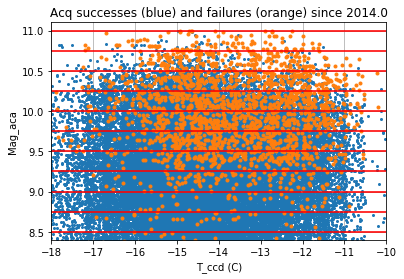

In [19]:
plot_fails_mag_aca_vs_t_ccd(mag_bins)

### Color != 1.5 fit (this is MOST acq stars)

In [20]:
# fit = fit_sota_model(data_all['color'] == 1.5, ms_disabled=True)
mask_no_1p5 = ((data_all['color'] != 1.5) & 
               (data_all['t_ccd'] > -17) & 
               (data_all['t_ccd'] < -10))

In [21]:
mag0s, mag1s = mag_bins[:-1], mag_bins[1:]
fits = {}
for m0, m1 in zip(mag0s, mag1s):
    print(m0, m1)
    fits[m0, m1] = fit_poly_model(mask_no_1p5 & mag_filter(m0, m1))

6.0 8.5
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 15600.6
Final fit statistic   = 664.987 at function evaluation 534
Data points           = 14996
Degrees of freedom    = 14993
Change in statistic   = 14935.6
   model.p0       -2.99719    
   model.p1       2.33477e-08 
   model.p2       0.0222427   
8.5 8.75
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 4116.16
Final fit statistic   = 261.784 at function evaluation 499
Data points           = 4006
Degrees of freedom    = 4003
Change in statistic   = 3854.38
   model.p0       -2.66409    
   model.p1       5.25086e-07 
   model.p2       0.00627572  
8.75 9.0
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 5319.34
Final fit statistic   = 407.903 at function evaluation 401
Data points           = 5184
Degrees of freedom    = 5181
Chang

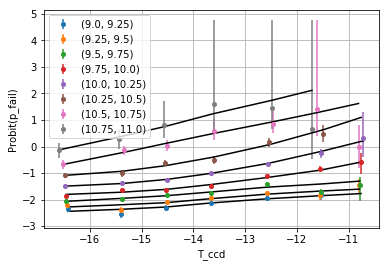

In [22]:
colors = [f'kC{i}' for i in range(9)]
for m0_m1, color in zip(list(fits)[3:], colors):
    fit = fits[m0_m1]
    m0, m1 = m0_m1
    plot_fit_grouped(fit.parvals, 't_ccd', 1.0, 
                     mask=mask_no_1p5 & mag_filter(m0, m1), 
                     probit=True, colors=color, label=str(m0_m1))
plt.grid()
# plt.ylim(-3.5, 0.5)
plt.ylabel('Probit(p_fail)')
plt.xlabel('T_ccd')
plt.legend();

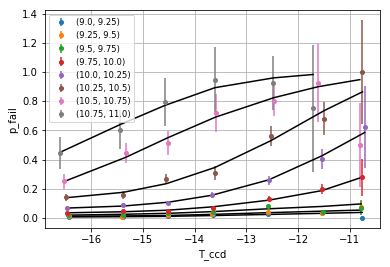

In [23]:
colors = [f'kC{i}' for i in range(9)]
for m0_m1, color in zip(list(fits)[3:], colors):
    fit = fits[m0_m1]
    m0, m1 = m0_m1
    plot_fit_grouped(fit.parvals, 't_ccd', 1.0, 
                     mask=mask_no_1p5 & mag_filter(m0, m1), 
                     probit=False, colors=color, label=str(m0_m1))
plt.grid()
plt.ylabel('p_fail')
plt.xlabel('T_ccd')
plt.legend(fontsize='small', loc='upper left');

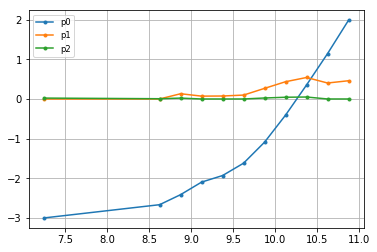

In [24]:
p0s = []
p1s = []
p2s = []
mags = []
for m0_m1, fit in fits.items():
    ps = fit.parvals
    m0, m1 = m0_m1
    mags.append((m0 + m1) / 2)
    p0s.append(ps[0])
    p1s.append(ps[1])
    p2s.append(ps[2])
plt.plot(mags, p0s, '.-', label='p0')
plt.plot(mags, p1s, '.-', label='p1')
plt.plot(mags, p2s, '.-', label='p2')
plt.legend(fontsize='small')
plt.grid()

### Histogram of warm pixel fraction

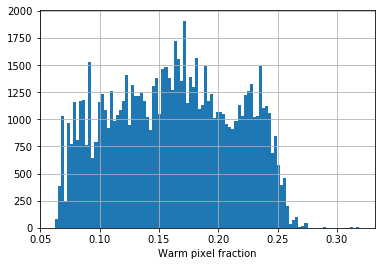

In [25]:
plt.hist(data_all['warm_pix'], bins=100)
plt.grid()
plt.xlabel('Warm pixel fraction');

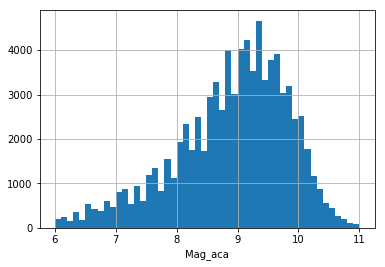

In [26]:
plt.hist(data_all['mag'], bins=np.arange(6, 11.1, 0.1))
plt.grid()
plt.xlabel('Mag_aca')

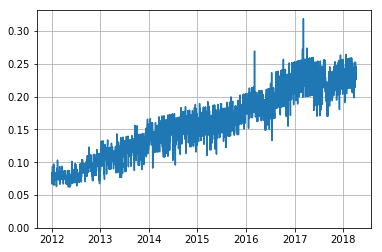

In [27]:
plt.plot(data_all['year'], data_all['warm_pix'])
plt.ylim(0, None)
plt.grid();

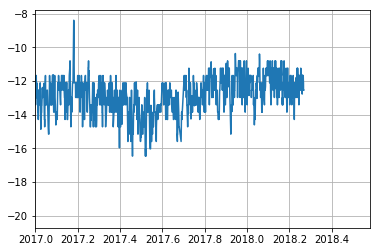

In [28]:
plt.plot(data_all['year'], data_all['t_ccd'])
# plt.ylim(0, None)
plt.xlim(2017.0, None)
plt.grid();